# Im gonna make the graph representations of the smiles molecules

In [1]:
#standard packages
import time
import torch
import pickle
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import TAGConv
from torch.nn import Sequential, Linear, ReLU

#visualise graphs
import networkx as nx
from torch_geometric.utils import to_networkx

#loading data
import pandas as pd
import os

#turning smiles into GRaphs
from torch_geometric.utils import from_smiles
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import Draw

## Loading data

In [2]:
#data path
data_path = "data/raw"

# Load train and test sets
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
test_df = pd.read_csv(os.path.join(data_path, "test.csv"))

### Exploring smiles

*OC(=O)CCCCCCCCC(=O)OC1COC2C(*)COC12
Data(x=[24, 9], edge_index=[2, 50], edge_attr=[50, 3], smiles='*OC(=O)CCCCCCCCC(=O)OC1COC2C(*)COC12')


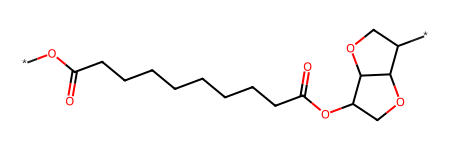

In [3]:
smiles_ex = train_df['SMILES'][5] # example from data set
print(smiles_ex)

# standard way to visualise the molecule
mol_pic = Chem.MolFromSmiles(smiles_ex)

#turn into specified data structure from smiles
data_ex = from_smiles(smiles_ex)

print(data_ex) 
mol_pic

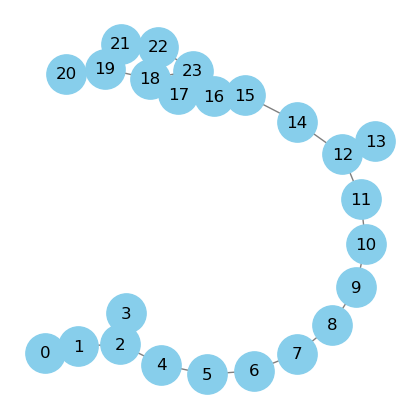

Ellipsis

In [4]:
# Visualise moelcules in graph way
def Vis_SMILES_G(data)->None:    
    G = to_networkx(data, to_undirected=True)

    plt.figure(figsize=(4,4))
    nx.draw(G, with_labels=True, node_color="skyblue", node_size=800, edge_color="gray")
    plt.show()
    return ...

Vis_SMILES_G(data_ex)

## General Mechanism
This built in function uses a commmonly used library known as RDKIT to turn smiles into molecules and then it is turned into a graph. From theRDKit library a lot of features node and edge wise are created immediatly. I just let the function caculate all of them.

### Understanding the features in the graph
Edges attr. Each bond has three features either 1 for single bond 2 for double bond 12 for aromatic bonds in the benzene ring.

Second column is for "stereochemistry / conjugation flag" means bond direction apperantly

Third column: aromatic flag. Just means if the molecule is in a benzene ring

In [5]:
# View edge attributes
data_ex.edge_attr

tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 1],
        [1, 0, 1],
        [2, 0, 1],
        [1, 0, 0],
        [2, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [2, 0, 1],
        [1, 0, 1],
        [2, 0, 1],
        [1, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])

### Molecule node features
Each of the pre built features is 9 features
- Feature1: Atomic number (H=1, C=6, O=8, etc., prob we should make one hot enc)
- Feature2: Chirality ( 1 if it is chiral, this if you mirror it stops being the same molecule. "think about how your hands look diffrentfrom eachother causethey are mirrored")
- Feature3: Degree of node
- Feature4: Formal Charge, (Charge estimated at that molecule)
- Feature5: Number of hydrogens attached
- Feature6: Hybridization (explains what type of sp orbital it has gives a number but we should make it one hot encoding )
- Feature7: Aromatic flag (is it aromatic bond, "deslocation of the bond", for us that usually means in a benzene ring)
- Feature8: Ring membership (is the atom part of a ring)

In [6]:
data_ex.x

tensor([[0, 0, 1, 5, 0, 0, 0, 0, 0],
        [8, 0, 2, 5, 0, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 0, 0],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 0, 0],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [8, 0, 2, 5, 0, 0, 3, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [0, 0, 1, 5, 0, 0, 0, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1]])

Ill create a new column with all the converted graphs

In [7]:
train_df["graph"] = train_df["SMILES"].apply(from_smiles)

# Very Important!
These are polymers which are very long chains, the actual graph would be a ery long chain of our monomers (The smiles we are actually given). So I am creating here a small function that will produce the corresponding molecule for a set lenght. These small chains are called oligomers.

I haven't checked the following code if it is correct but it provides an output I will check robustness another day

In [8]:
from rdkit import Chem

def _neighbor_idx(mol, atom_idx):
    """Return the single neighbor index of a star atom."""
    nbrs = [n.GetIdx() for n in mol.GetAtomWithIdx(atom_idx).GetNeighbors()]
    if len(nbrs) != 1:
        raise ValueError(f"Star atom at idx {atom_idx} does not have exactly one neighbor.")
    return nbrs[0]

def SMILES_To_Oligomer(monomer_smiles: str, length: int, cap_ends: bool = True) -> str:
    """
    Build an oligomer SMILES by connecting monomer units at '*' with SINGLE bonds.
    First '*' in the SMILES string = HEAD, second '*' = TAIL.
    If cap_ends=True, terminal '*' atoms are removed (implicit H completes valence).
    """
    if monomer_smiles.count("*") != 2:
        raise ValueError("Monomer must have exactly 2 connection points [*].")

    # find positions of '*' in the SMILES string
    star_positions = [i for i, ch in enumerate(monomer_smiles) if ch == "*"]
    if len(star_positions) != 2:
        raise ValueError("Could not locate exactly 2 '*' in SMILES string.")

    # RDKit mol
    mono = Chem.MolFromSmiles(monomer_smiles)
    if mono is None:
        raise ValueError("Invalid monomer SMILES.")

    # collect star atom indices in same order as in SMILES string
    atoms = list(mono.GetAtoms())
    stars = [a.GetIdx() for a in atoms if a.GetSymbol() == "*"]

    # this mapping isn't guaranteed from RDKit, so we align with string order
    # pick the atom whose order in MolToSmiles matches the SMILES positions
    # simpler assumption: just treat the first in list as HEAD, second as TAIL
    head_star, tail_star = stars[0], stars[1]

    # Start oligomer
    oligomer = Chem.Mol(mono)
    open_end = tail_star  # grow from tail

    for _ in range(length - 1):
        mono2 = Chem.Mol(mono)
        stars2 = [a.GetIdx() for a in mono2.GetAtoms() if a.GetSymbol() == "*"]
        if len(stars2) != 2:
            raise ValueError("Attachment monomer lost its two '*' atoms.")
        head2, tail2 = stars2  # head2 = first star of new monomer, tail2 = second

        combined = Chem.CombineMols(oligomer, mono2)
        rw = Chem.RWMol(combined)
        offset = oligomer.GetNumAtoms()

        # indices inside combined
        open_star_idx = open_end
        head_idx = head2 + offset
        tail_idx = tail2 + offset

        # connect neighbor of open_end ↔ neighbor of head2
        n1 = _neighbor_idx(rw, open_star_idx)
        n2 = _neighbor_idx(rw, head_idx)
        rw.AddBond(n1, n2, Chem.BondType.SINGLE)

        # remove consumed stars
        for idx in sorted([open_star_idx, head_idx], reverse=True):
            rw.RemoveAtom(idx)

        # adjust tail_idx after deletions
        removed = sorted([open_star_idx, head_idx])
        for r in removed:
            if tail_idx > r:
                tail_idx -= 1

        oligomer = rw.GetMol()
        open_end = tail_idx  # carry forward the new tail

    if cap_ends:
        rw = Chem.RWMol(oligomer)
        end_stars = [a.GetIdx() for a in rw.GetAtoms() if a.GetSymbol() == "*"]
        for idx in sorted(end_stars, reverse=True):
            rw.RemoveAtom(idx)
        oligomer = rw.GetMol()

    Chem.SanitizeMol(oligomer)
    return Chem.MolToSmiles(oligomer)


def SMILES_To_Oligomer_Graph(monomer_smiles: str, length: int):
    oligo_smiles = SMILES_To_Oligomer(monomer_smiles, length, cap_ends=True)
    return from_smiles(oligo_smiles)


 Showing a simple example of the molecule vs its oligomer

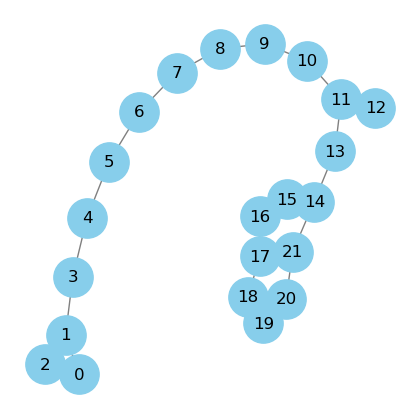

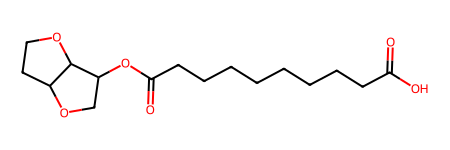

In [9]:
#Example
oligomer_ex = SMILES_To_Oligomer_Graph(smiles_ex, 1) # Generate graph data
Vis_SMILES_G(oligomer_ex) # visualise graph form
mol_ex = Chem.MolFromSmiles(SMILES_To_Oligomer(smiles_ex, 1))
mol_ex # visualise in chemical formula for

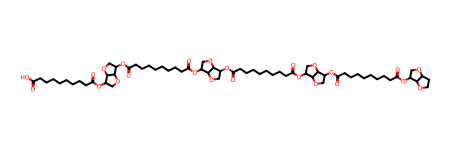

In [10]:
# Showing in alternative length form
mol_ex = Chem.MolFromSmiles(SMILES_To_Oligomer(smiles_ex, 4))
mol_ex